In [1]:
import sys
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import joblib

In [2]:
samples = joblib.load('samples.sav')
# list_CpGs = joblib.load('list_CpGs.sav')
# list_patterns = joblib.load('list_patterns.sav')
# list_each_cpg = joblib.load('list_each_cpg.sav')
# CpG_positions = joblib.load('CpG_positions.sav')
CpG_num = joblib.load('CpG_num.sav')
colors = joblib.load('colors.sav')
CpG_targets = joblib.load('CpG_targets.sav')

In [3]:
set(samples["Group ID"])

{'CD', 'CL', 'Ctrl', 'DD', 'FD', 'MN', 'MP', 'MU', 'TR'}

In [4]:
sel_group = ['Ctrl', 'FD', 'MN', 'MP']
samples2 = samples.loc[samples["Group ID"].isin(sel_group),]
list_CpGs2 = {}
list_patterns2 = {}
numCpG = {}
for target in CpG_targets:
    list_CpGs2[target] = list_CpGs[target].loc[list_CpGs[target]["group"].isin(sel_group),]
#     list_patterns2[target] = list_patterns[target].loc[list_patterns[target]["group"].isin(sel_group),]
    if target not in numCpG.keys():
        numCpG[target] = list_CpGs2[target].iloc[:,3:].shape[1]

In [5]:
samples2["ID"]
numCpG

{'cg15289427': 14, 'cg22797031': 10, 'cg27630153': 15, 'cg19586199': 9}

In [6]:
training_ratio = 0.7
ss_ctrl = samples2.loc[samples2["Group ID"].isin(['Ctrl']),]
training_set_ctrl = ss_ctrl.sample(frac=training_ratio, random_state=11).ID.values.tolist()
validation_set_ctrl = list(set(ss_ctrl.ID.values.tolist()) - set(training_set_ctrl))

# samples2.loc[samples2["ID"].isin(training_set_ctrl),"Group ID"] = "Ctrl Training"
# # print(samples)
# for target in CpG_targets:
#     print(target)
#     for idd in training_set_ctrl:
#         list_CpGs2[target].loc[list_CpGs2[target]["id"]==idd,"group"] = "Ctrl Training"

ss_FD = samples2.loc[samples2["ID"].isin(["FD_21a","FD_22a","FD_23a","FD_24a","FD_25a","FD_26a","FD_27a","FD_28a","FD_29a","FD_30a","FD_31a","FD_32a","FD_33a","FD_34a","FD_35a","FD_36a","FD_37a","FD_38a","FD_39a","FD_40a","FD_41a","FD_42a","FD_43a","FD_44a","FD_45a","FD_46a","FD_53a","FD_54a","FD_55a","FD_56a","FD_57a","FD_58a","FD_59a","FD_60a",
]),]
training_set_FD = ss_FD.sample(frac=training_ratio, random_state=11).ID.values.tolist()
validation_set_FD = list(set(ss_FD.ID.values.tolist()) - set(training_set_FD))

# samples2.loc[samples2["ID"].isin(validation_set_FD),"Group ID"] = "FD Training"
# # print(samples)
# for target in CpG_targets:
#     print(target)
#     for idd in validation_set_FD:
#         list_CpGs2[target].loc[list_CpGs2[target]["id"]==idd,"group"] = "FD Training"

In [8]:
validation_set_FD

['FD_45a',
 'FD_53a',
 'FD_39a',
 'FD_22a',
 'FD_38a',
 'FD_34a',
 'FD_35a',
 'FD_40a',
 'FD_55a',
 'FD_29a']

In [9]:
sum_reads = []
for target in CpG_targets:
    print(target)
    for s in training_set_FD:
        print(".", end="")
        ttr = list_CpGs2[target].loc[list_CpGs2[target]["id"]==s,].shape[0]
        sum_reads.append(ttr)
    print()
print(sum(sum_reads))

cg15289427
......................
cg22797031
......................
cg27630153
......................
cg19586199
......................
1649985


In [10]:
len(training_set_FD)

22

In [11]:
training_set = training_set_ctrl + training_set_FD
validation_set = validation_set_ctrl + validation_set_FD

In [12]:
joblib.dump([samples2, CpG_targets, numCpG,
            training_set, validation_set,
            list_CpGs2], 'RF_before_training_NPM1.sav') 

['RF_before_training_NPM1.sav']

In [3]:
[samples2, CpG_targets, numCpG,
            training_set, validation_set,
            list_CpGs2] = joblib.load('RF_before_training.sav')


In [5]:
max_depth = 5

In [14]:

RFs = {}
for target in CpG_targets:
    print(target)
    X = np.empty((0, numCpG[target]))
    Y = []
    for idd in samples2["ID"]:
        if idd in training_set:
            g = samples2["Group ID"].loc[samples2["ID"]==idd].values
            t = list_CpGs2[target].loc[list_CpGs2[target]["id"]==idd,]
            t = t.iloc[:,3:].values
#             print(t.shape)
#             print(X.shape)
            X = np.concatenate((X, t))
            Y += [g] * t.shape[0]
    print("training data...")
#     print(X.shape)
#     print(len(Y))
    RFs[target] = RandomForestClassifier(max_depth=max_depth, random_state=0)
    RFs[target].fit(X, np.ravel(Y))

joblib.dump(RFs, "Random_forest_models_NPM1.sav")

cg15289427
training data...
cg22797031
training data...
cg27630153
training data...
cg19586199
training data...


['Random_forest_models_NPM1.sav']

In [15]:

res_RFs = []
for idd in samples2["ID"]:
    print(".", end="")
    g = samples2["Group ID"].loc[samples2["ID"]==idd].values[0]
    pp = []
    for target in CpG_targets:
#         print(target)
        t = list_CpGs2[target].loc[list_CpGs2[target]["id"]==idd,]
#         if t.shape[0] < 100:
#             continue
#         else:
        t = t.iloc[:,3:].values
        r = RFs[target].predict(t).tolist()
        pp.append(r.count("FD")/len(r))
#         print(pp)
#     print(pp)
    p = sum(pp)/len(pp)
    res_RFs.append([g, idd, p])
# print(res_RFs)
res_RFs = pd.DataFrame(res_RFs, columns=["group", "id", "anomaly"])
    

............................................................................................................................................................

In [16]:
res_RFs 

,group,id,anomaly
0,Ctrl,Ctrl_BX,0.046345
1,Ctrl,Ctrl_BY,0.031791
2,Ctrl,Ctrl_BZ,0.038746
3,Ctrl,Ctrl_CA,0.021016
4,Ctrl,Ctrl_CB,0.033743
...,...,...,...
151,MP,MP_56d,0.159452
152,MP,MP_56e,0.834437
153,MP,MP_57b,0.096712
154,MP,MP_58a,0.084629


In [17]:
# res_RFs = joblib.load('/home/joseph/Dropbox/Work/Manuscripts/2020_Kuo_Leukemia/figures/benchmark/res_random_forest'+str(max_depth)+'.sav')
res_RFs.to_csv("/home/joseph/Dropbox/Work/Manuscripts/2020_Kuo_Leukemia/figures/benchmark/res_random_forest"+str(max_depth)+"_NPM1.csv", index=False)
res_RFs

,group,id,anomaly
0,Ctrl,Ctrl_BX,0.046345
1,Ctrl,Ctrl_BY,0.031791
2,Ctrl,Ctrl_BZ,0.038746
3,Ctrl,Ctrl_CA,0.021016
4,Ctrl,Ctrl_CB,0.033743
...,...,...,...
151,MP,MP_56d,0.159452
152,MP,MP_56e,0.834437
153,MP,MP_57b,0.096712
154,MP,MP_58a,0.084629


In [39]:
res_RFs = pd.read_csv("/home/joseph/Dropbox/Work/Manuscripts/2020_Kuo_Leukemia/figures/benchmark/res_random_forest"+str(max_depth)+"_NPM1.csv")
res_RFs.loc[res_RFs.id.isin(training_set) & res_RFs.group.isin(["Ctrl"]),"group"] = "Control (Training)"
res_RFs.loc[res_RFs.id.isin(validation_set) & res_RFs.group.isin(["Ctrl"]),"group"] = "Control (Validation)"

['Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl' 'Ctrl'
 'Ctrl' 'Ctrl' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD'
 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD'
 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD'
 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'FD' 'MP' 'MN' 'MN' 'MN' 'MN' 'MN'
 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MN' 'MP' 'MP'
 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP'
 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP' 'MP']
['Control (Validation)' 'Control (Validation)' 'Control (Training)'
 'Control (Tra

156

In [44]:
colors["Control (Training)"] = '#949494'
colors["Control (Validation)"] = '#2e2e2e'
[treshold_AMLscore,treshold_randomforest,treshold_autoencoder1,treshold_autoencoder5] = joblib.load("thresholds.sav")

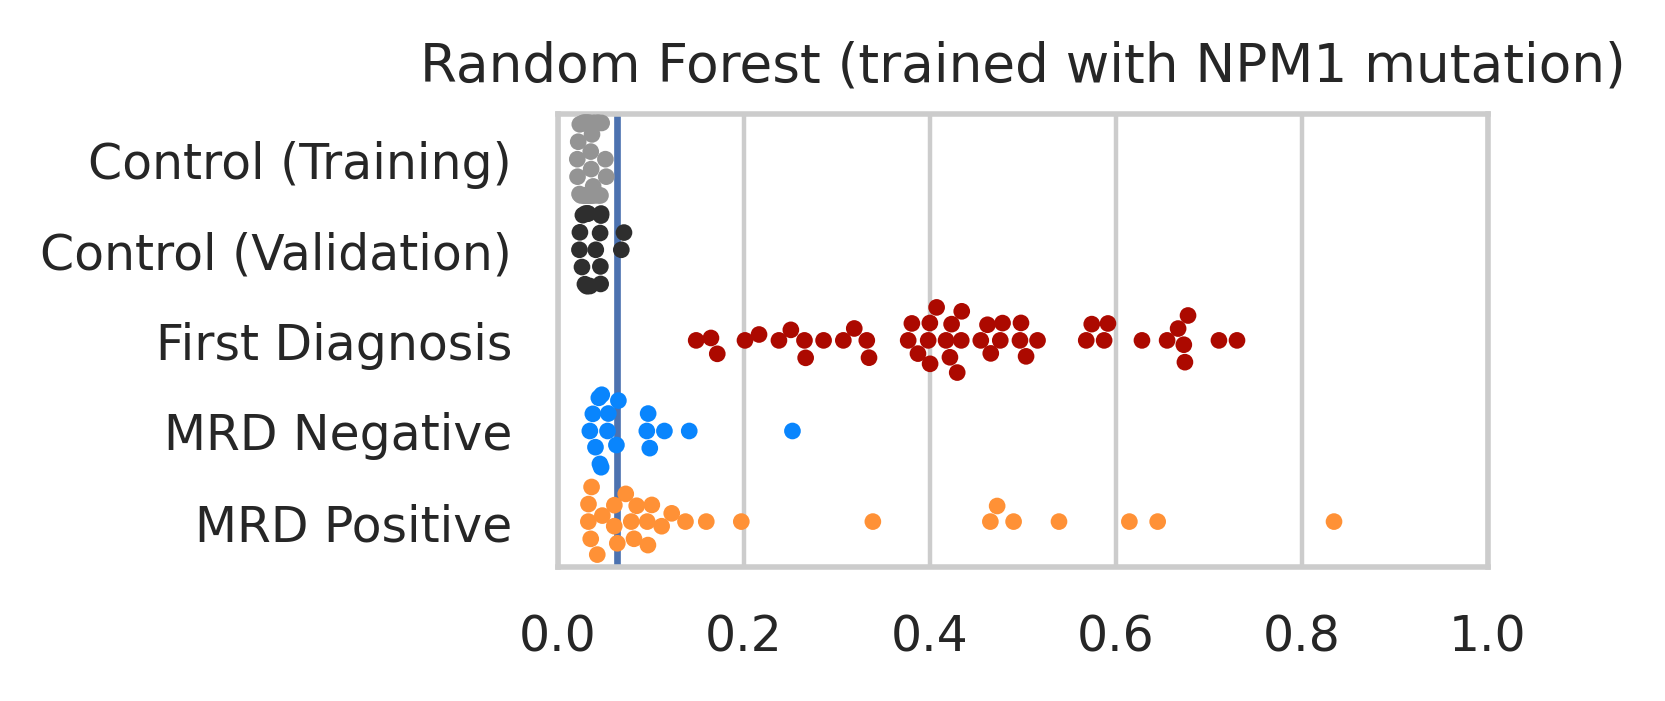

In [45]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

####### Figures #########
f, axs = plt.subplots(1, 1, figsize=(3, 1.5), dpi=400)
# sns.boxplot(x="group", y="anomaly_ratio", data=anomaly["Mean"],
#             ax=axs, hue="group", palette=colors, dodge=False, showfliers = False)
sns.swarmplot(y="group", x="anomaly", data=res_RFs,
              ax=axs, hue="group", palette=colors, dodge=False, color=".25", size=3,
              order=["Control (Training)", "Control (Validation)", "FD", "MN", "MP"])
axs.set_title("Random Forest (trained with NPM1 mutation)")
axs.set_xlim([0,1])
axs.set(xlabel='')
axs.set(ylabel='')
axs.set_yticklabels(["Control (Training)", "Control (Validation)", "First Diagnosis","MRD Negative", "MRD Positive"], rotation=0, ha='right')
axs.get_legend().remove()
axs.axvline(treshold_randomforest, 0,1)
# handles, labels = axs.get_legend_handles_labels()
# axs.legend(title='', loc=2,
#            handles= handles, labels=["Control (Training)", "Control (Validation)", "First Diagnosis",
#                               "MRD Negative", "MRD Positive"])
f.savefig("/home/joseph/Dropbox/Work/Manuscripts/2020_Kuo_Leukemia/figures/random_forest_NPM1.png", bbox_inches='tight', dpi=600)
plt.show()